<a href="https://colab.research.google.com/github/AliciaFalconCaro/MedicalImageClassificationExample/blob/main/MedicalimageClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will perform some basic medical image classification techniques.
The purpose is to compare traditional techniques with DL techniques.

For this mini-project, we will use the public dataset available here: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic/data

The dataset is already separated in two folders: train and test. It contains multiple images from different skin cancers. In total, there are 6 classes of cancer in the dataset.

Let's start with loading the data and having a quick look at it

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = './local_dir/Skin_Cancer_ISIC_Data/Train'
test_dir = './local_dir/Skin_Cancer_ISIC_Data/Test'

batch_size=32

# Create ImageDataGenerator with rescaling and optional augmentation
#since we are using DL with CNN, no more propocessing steps are necessary. However, they could improve the accuracy/performance of the model
#we could use data augmentation or feature extraction techniques

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale/normalize pixel values to [0, 1]
    #You can add data augmentation here
    # rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    # shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    validation_split=0.2 #let's separate training into training and validation (20% validation)
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing datasets
imageSize = (64, 64)  # Resize to 64x64

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=imageSize,  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',
    shuffle=True,  # Shuffle the dataset
    subset='training' # set as training data
    )

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=imageSize,  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',
    shuffle=True,  # Shuffle the dataset
    subset='validation' # set as training data
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=imageSize,  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Get class names from the generator
class_names = train_generator.class_indices

print ("Class names:", class_names)
print ("Number of classes:", len(class_names))

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Class names: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Number of classes: 9


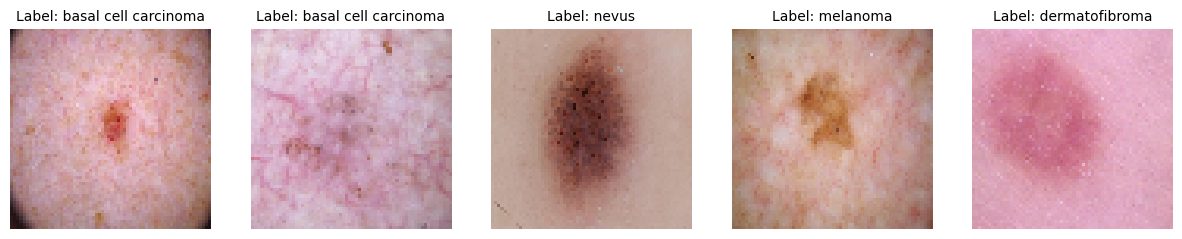

In [2]:
#Let's also see the first 5 images
import matplotlib.pyplot as plt
import numpy as np


def display_images(images, labels, le, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        ax.set_title(f"Label: {le.inverse_transform([label_index])[0]}", fontsize=10)
        ax.axis('off')
    plt.show()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(class_names.keys())) #so we can show the labels on each displayed image

images, labels = train_generator.__next__() #get first batch of data

display_images(images, labels, le)

<ipython-input-21-119c85b57818>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(class_labels, rotation=45, ha='right') # Added this line to align labels


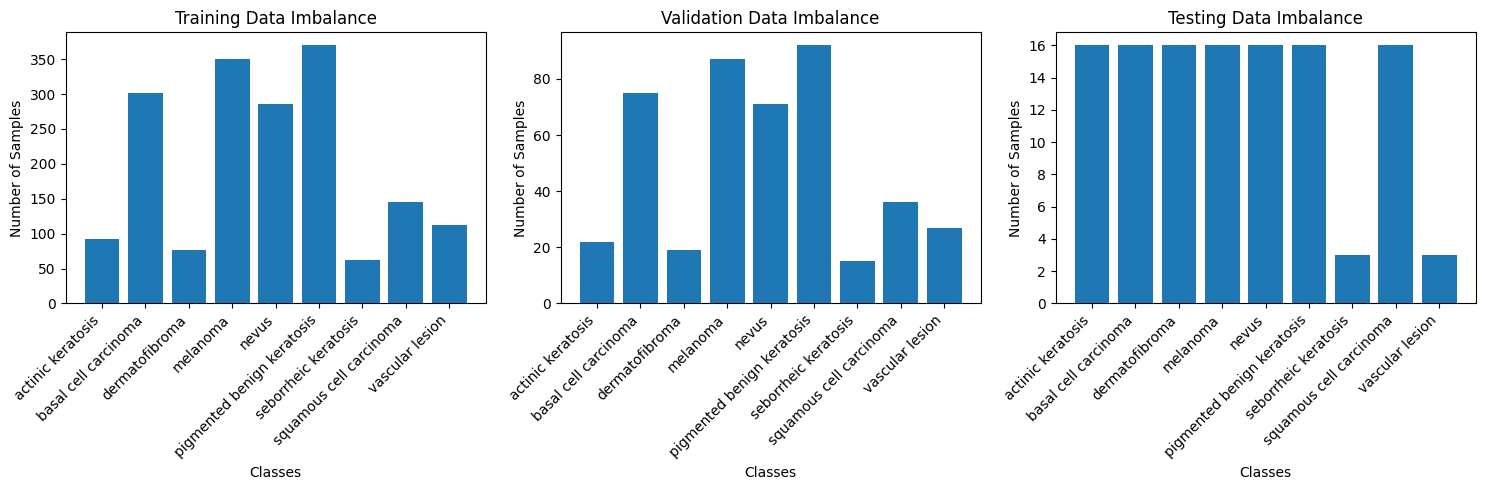

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data_imbalance(generators, titles):

    fig, axes = plt.subplots(1, len(generators), figsize=(15, 5))  # 1 row, 3 columns

    for i, (generator, title) in enumerate(zip(generators, titles)):
        class_counts = generator.classes
        class_labels = list(generator.class_indices.keys())
        count_per_class = np.bincount(class_counts)

        axes[i].bar(class_labels, count_per_class)
        axes[i].set_title(title)
        axes[i].set_xlabel('Classes')
        axes[i].set_ylabel('Number of Samples')
        # Rotate x-axis labels and align them to the right
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_xticklabels(class_labels, rotation=45, ha='right') # Added this line to align labels


    plt.tight_layout()
    plt.show()

# Visualize data imbalance using subplots
generators = [train_generator, val_generator, test_generator]
titles = ['Training Data Imbalance', 'Validation Data Imbalance', 'Testing Data Imbalance']
visualize_data_imbalance(generators, titles)

In [14]:
from tensorflow.keras import layers, models

# Define CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # labels are categorical
              metrics=['accuracy'])

# View model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,361 (2.61 MB)

 Trainable params: 684,361 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
batch_size=32

TrainedModelCNN = model.fit(train_generator,validation_data=val_generator, epochs=50)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 247ms/step - accuracy: 0.1740 - loss: 2.1172 - val_accuracy: 0.3378 - val_loss: 2.0637
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.3483 - loss: 1.8324 - val_accuracy: 0.3041 - val_loss: 1.8256
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.4168 - loss: 1.6393 - val_accuracy: 0.3739 - val_loss: 1.7823
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.4171 - loss: 1.6007 - val_accuracy: 0.4302 - val_loss: 1.6381
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.4805 - loss: 1.4863 - val_accuracy: 0.4302 - val_loss: 1.6440
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.5158 - loss: 1.4108 - val_accuracy: 0.3784 - val_loss: 1.6825
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.5034 - loss: 1.4229 - val_accuracy: 0.4369 - val_loss: 1.6917
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.5129 - loss: 1.3672 - val_accu

In [10]:
#save trained model
model.save('TrainedModelCNN.keras') #can also be saved as tensorflow format instead

In [11]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3132 - loss: 2.2074
Test Accuracy: 0.32


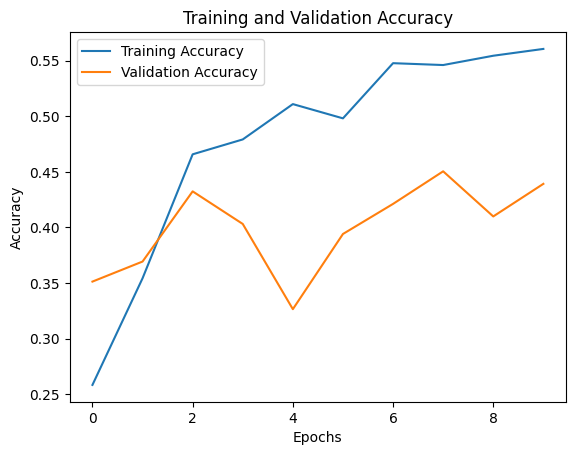

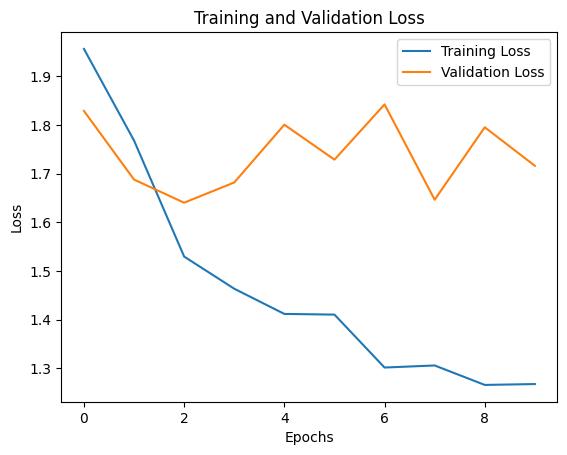

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(TrainedModelCNN.history['accuracy'], label='Training Accuracy')
plt.plot(TrainedModelCNN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(TrainedModelCNN.history['loss'], label='Training Loss')
plt.plot(TrainedModelCNN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


We visualise the results of the test data with a confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions on the test set
y_pred = model.predict(test_generator)
y_true = np.array([y for _, y in test_generator])

# Convert to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



If we wanted a more detailed evaluation of the model performance, we could obtain and print the classification report:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
